# 06b — Target Visualizations (interactive + static + GIS export)

This notebook visualizes the shortlisted targets from **06_targets_shortlist**:
- **Interactive map (Folium)** with popups showing RF prob, Bayesian mean/std, combined score.
- **Static PNG** with grid heatmap underlay and numbered target markers.
- **GeoJSON / GeoPackage** exports for GIS use.

Outputs:
- `figures/targets_map_<labelset>.html`
- `figures/targets_static_<labelset>.png`
- `data/processed/targets.geojson`, `data/processed/targets.gpkg`


In [78]:
# 1) Imports & setup
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

# Make 'src/' importable if running from notebooks/
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

os.makedirs("figures", exist_ok=True)


In [79]:
#2) Load data (targets, grid, label set)

# Detect label set
if os.path.exists(project_root / "data/processed/y_labels_crit.npy"):
    LABEL_SET = "critical"
else:
    LABEL_SET = "all"
print("Label set:", LABEL_SET)

# Load grid (authoritative geometry)
grid = joblib.load(project_root / "data/processed/grid_gdf.joblib")
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)

# Load targets table from 06 (must exist)
targets_csv = project_root / "data/processed/targets.csv"
if not os.path.exists(targets_csv):
    raise FileNotFoundError("Missing data/processed/targets.csv. Run 06_targets_shortlist first.")
targets = pd.read_csv(targets_csv)

# Attach geometry from lon/lat (ensure EPSG:4326)
targets_gdf = gpd.GeoDataFrame(
    targets.copy(),
    geometry=gpd.points_from_xy(targets["lon"], targets["lat"]),
    crs=4326
)

print(f"Loaded {len(targets_gdf)} targets")
targets_gdf.head(3)


Label set: critical
Loaded 50 targets


,lon,lat,rf_p,bayes_mean,bayes_std,geometry
0,-90.249355,37.520603,0.301231,0.096646,0.010460,POINT (-90.24936 37.5206)
1,-90.749355,38.470603,0.301231,0.121944,0.010793,POINT (-90.74936 38.4706)
2,-90.549355,37.870603,0.301231,0.074330,0.008106,POINT (-90.54936 37.8706)


In [80]:
#3) Make a combined score (prob high, uncertainty low)

# Combined score: RF probability × (1 - normalized Bayes std)
rf = targets_gdf["rf_p"].values
std = targets_gdf["bayes_std"].values
std_norm = (std - np.nanmin(std)) / (np.nanmax(std) - np.nanmin(std) + 1e-12)
score = rf * (1.0 - std_norm)
targets_gdf["score"] = score

# Rank by RF prob (or score if you prefer); we’ll show both in popups
targets_gdf = targets_gdf.sort_values("rf_p", ascending=False).reset_index(drop=True)
targets_gdf["rank"] = np.arange(1, len(targets_gdf) + 1)
targets_gdf.head(3)


,lon,lat,rf_p,bayes_mean,bayes_std,geometry,score,rank
0,-90.249355,37.520603,0.301231,0.096646,0.010460,POINT (-90.24936 37.5206),0.132365,1
1,-90.749355,38.470603,0.301231,0.121944,0.010793,POINT (-90.74936 38.4706),0.118125,2
2,-90.549355,37.870603,0.301231,0.074330,0.008106,POINT (-90.54936 37.8706),0.233059,3


In [ ]:
# 4) Interactive Folium map (version-agnostic colormap)

import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
import matplotlib.cm as mpcm
import matplotlib.colors as mcolors
import numpy as np

# Center map
center = [targets_gdf["lat"].mean(), targets_gdf["lon"].mean()]
m = folium.Map(location=center, zoom_start=6, tiles="CartoDB positron")

# Color scale by RF probability (build from matplotlib so it always exists)
rf_vals = targets_gdf["rf_p"].values
vmin, vmax = float(rf_vals.min()), float(rf_vals.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
mpl_cmap = mpcm.get_cmap("viridis")

def prob_to_color(p):
    return mcolors.to_hex(mpl_cmap(norm(p)))

# Folium legend (continuous)
cmap = cm.LinearColormap(
    colors=[mcolors.to_hex(mpl_cmap(x)) for x in np.linspace(0, 1, 256)],
    vmin=vmin, vmax=vmax
)
cmap.caption = "RF probability"

mc = MarkerCluster(name="Top targets").add_to(m)

# Normalize score for marker size (3..12 px)
s = targets_gdf["score"].values
s_norm = (s - s.min()) / (s.max() - s.min() + 1e-12)

for _, row in targets_gdf.iterrows():
    color = prob_to_color(row["rf_p"])
    radius = 3 + 9 * s_norm[row["rank"] - 1]  # rank is 1-based

    html = f"""
    <b>Rank:</b> {int(row['rank'])}<br>
    <b>RF prob:</b> {row['rf_p']:.3f}<br>
    <b>Bayes mean:</b> {row['bayes_mean']:.3f}<br>
    <b>Bayes std:</b> {row['bayes_std']:.3f}<br>
    <b>Score (p × (1-σ)):</b> {row['score']:.3f}<br>
    <b>Lon, Lat:</b> {row['lon']:.4f}, {row['lat']:.4f}
    """
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=float(radius),
        color=color,
        fill=True,
        fill_opacity=0.85,
        weight=1,
        popup=folium.Popup(html, max_width=320),
    ).add_to(mc)

cmap.add_to(m)
folium.LayerControl().add_to(m)
html_path = project_root / f"figures/targets_map_{LABEL_SET}.html"
m.save(html_path)
print(f"Saved {html_path}")

Saved c:\Users\angel\ore-exploration-ml\figures\targets_map_critical.html


C:\Users\angel\AppData\Local\Temp\ipykernel_23776\2168891193.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl_cmap = mpcm.get_cmap("viridis")


Background RF layer: present


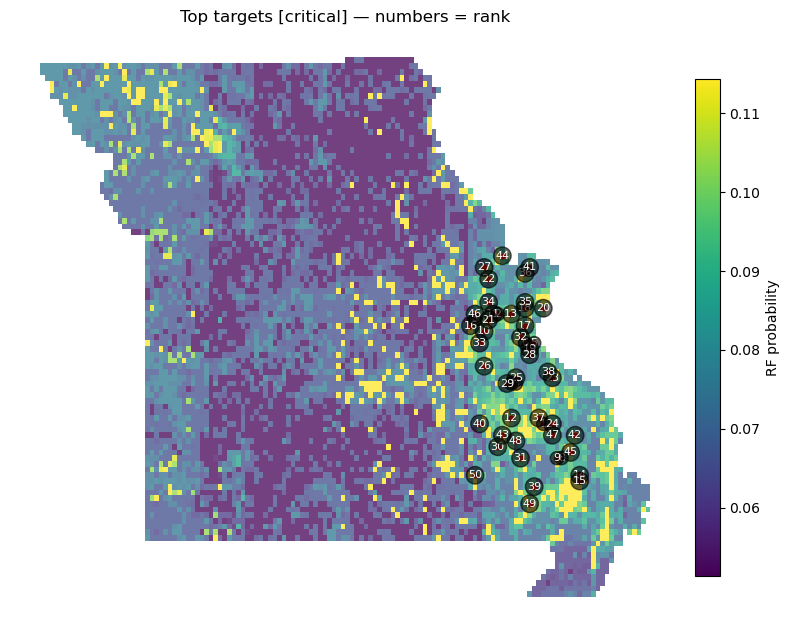

Saved figures/targets_static_critical.png


In [82]:
# 5) Static map (grid heatmap underlay + numbered targets)

import matplotlib as mpl

# Try to get a full-grid RF probability background for context
# If you saved it in 03 as rf_probs_<labelset>.npy, use it; else fall back to target-only overlay.
rf_bg_path = f"data/processed/rf_probs_{LABEL_SET}.npy"
have_bg = os.path.exists(rf_bg_path) and (len(grid) == np.load(rf_bg_path).shape[0])
rf_bg = np.load(rf_bg_path) if have_bg else None
print("Background RF layer:", "present" if have_bg else "absent")

# Reproject to Web Mercator for plotting aesthetics
grid_3857 = grid.to_crs(3857)
targets_3857 = targets_gdf.to_crs(3857)

fig, ax = plt.subplots(figsize=(8, 9))

if have_bg:
    vmin, vmax = np.nanpercentile(rf_bg, [5, 95])
    grid_3857.assign(rf_p=rf_bg).plot(
        column="rf_p", ax=ax, cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.75
    )
    cb = plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap="viridis"
    )
    cbar = fig.colorbar(cb, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("RF probability")

# Overlay numbered targets
targets_3857.plot(ax=ax, color="red", markersize=12, alpha=0.9)
for _, r in targets_3857.iterrows():
    cx, cy = r.geometry.x, r.geometry.y
    ax.text(cx, cy, str(int(r["rank"])),
            color="white", fontsize=8, ha="center", va="center",
            bbox=dict(facecolor="black", alpha=0.6, boxstyle="circle,pad=0.15"))

ax.set_title(f"Top targets [{LABEL_SET}] — numbers = rank", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
png_path = f"figures/targets_static_{LABEL_SET}.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved {png_path}")


In [83]:
# 6) GIS exports (GeoJSON + GeoPackage)

# Keep important columns and geometry
export_cols = ["rank", "lon", "lat", "rf_p", "bayes_mean", "bayes_std", "score", "geometry"]
out_gdf = targets_gdf[export_cols].copy()

# GeoJSON
geojson_path = project_root / "data/processed/targets.geojson"
out_gdf.to_file(geojson_path, driver="GeoJSON")

# GeoPackage
gpkg_path = project_root / "data/processed/targets.gpkg"
out_gdf.to_file(gpkg_path, layer=f"targets_{LABEL_SET}", driver="GPKG")

print(f"Saved {geojson_path} and {gpkg_path}")


Saved c:\Users\angel\ore-exploration-ml\data\processed\targets.geojson and c:\Users\angel\ore-exploration-ml\data\processed\targets.gpkg
